In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
print("Modules imported")

Modules imported


The k-means algorithm searches for a **pre-determined** number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

    * The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
    * Each point is closer to its own cluster center than to other cluster centers.


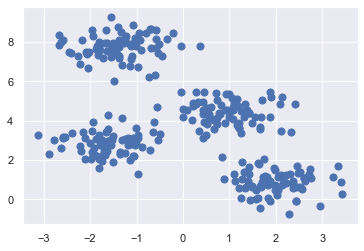

In [2]:
# generate a two-dimensional dataset containing four distinct blobs
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

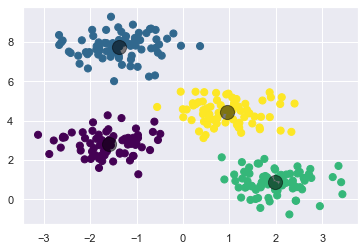

In [4]:
# visualize the results by plotting the data colored by these labels 
# plot the cluster centers as determined by the k-means estimator:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The k-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.  The typical approach to k-means involves an intuitive iterative approach known as _expectation–maximization_.

Expectation–maximization **(E–M)** is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:

    Guess some cluster centers
    
    Repeat until converged
    
        E-Step: assign points to the nearest cluster center
        M-Step: set the cluster centers to the mean
        
        
Here the "E-step" or **"Expectation step"** is so-named because it involves updating our expectation of which cluster each point belongs to. 

The "M-step" or **"Maximization step"** is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

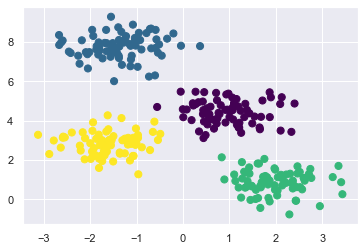

In [5]:
# The k-Means algorithm 
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

        The globally optimal result may not be achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

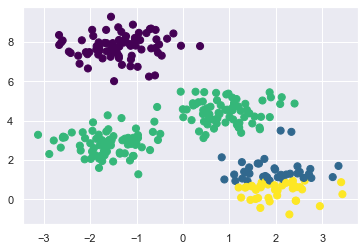

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');